In [7]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linprog
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.size'] = 24

hours = np.arange(7, 22)
busy = np.array([ 5, 15, 30, 20, 30, 55, 80, 45, 25, 20, 25, 40, 25, 20, 10])
idle = np.array([25, 20, 10, 25, 30, 20, 10, 35, 45, 45, 25, 15, 20, 15, 20])
optimal = (busy / 0.8).astype(np.int)
print(np.sum(busy) / (np.sum(busy) + np.sum(idle)))
print(np.sum(busy) / (np.sum(optimal)))
print(optimal)

0.5527950310559007
0.8061594202898551
[  6  18  37  25  37  68 100  56  31  25  31  50  31  25  12]


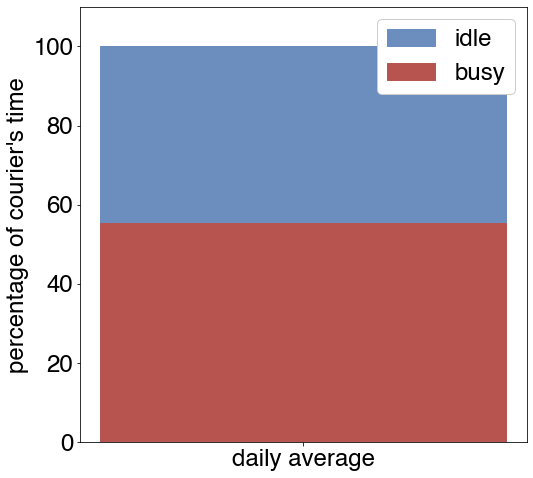

In [27]:
_, ax = plt.subplots(figsize = (8, 8))
ax.set_ylabel('percentage of courier\'s time')
ax.set_ylim(0, max(np.max(optimal), np.max(np.add(idle, busy))) + 10)
ax.bar(["daily average"], 100 * np.sum(idle) / (np.sum(busy) + np.sum(idle)), width = 1, bottom = 100 * np.sum(busy) / (np.sum(busy) + np.sum(idle)), label = 'idle', color = '#6C8EBF', edgecolor = '#6C8EBF')
ax.bar(["daily average"], 100 * np.sum(busy) / (np.sum(busy) + np.sum(idle)), width = 1, label = 'busy', color = '#B85450', edgecolor = '#B85450')
ax.legend(loc = 'upper right', facecolor = 'white', framealpha = 1)
plt.savefig('2020-07-16-shifts-planning--hourly-couriers-engagement-zoom-out.svg')

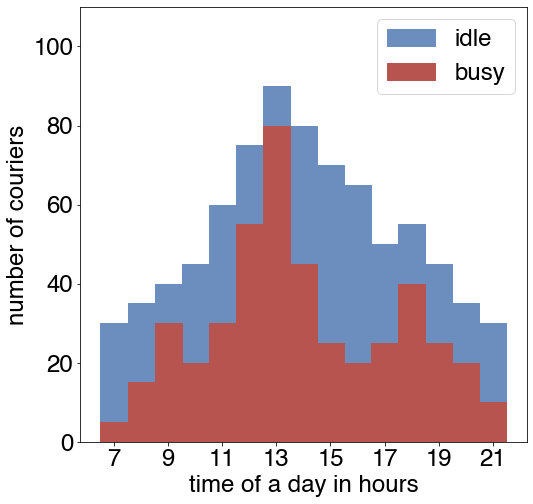

In [9]:
_, ax = plt.subplots(figsize = (8, 8))
ax.set_xlabel('time of a day in hours')
ax.set_ylabel('number of couriers') 
ax.set_ylim(0, max(np.max(optimal), np.max(np.add(idle, busy))) + 10)
ax.bar(hours, idle, width = 1, bottom = busy, label = 'idle', color = '#6C8EBF', edgecolor = '#6C8EBF')
ax.bar(hours, busy, width = 1, label = 'busy', color = '#B85450', edgecolor = '#B85450')
plt.xticks(np.delete(hours, np.arange(1, hours.size, 2))) 
ax.legend(loc = 'upper right')
plt.savefig('2020-07-16-shifts-planning--hourly-couriers-engagement-zoom-in.svg')

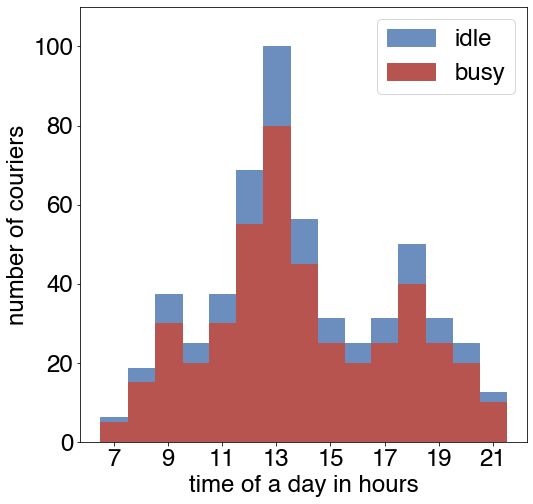

In [10]:
_, ax = plt.subplots(figsize = (8, 8))
ax.set_xlabel('time of a day in hours')
ax.set_ylabel('number of couriers')
ax.set_ylim(0, max(np.max(optimal), np.max(np.add(idle, busy))) + 10)
ax.bar(hours, (busy / 0.8) - busy, width = 1, bottom = busy, label = 'idle', color = '#6C8EBF', edgecolor = '#6C8EBF')
ax.bar(hours, busy, width = 1, label = 'busy', color = '#B85450', edgecolor = '#B85450')
plt.xticks(np.delete(hours, np.arange(1, hours.size, 2)))
ax.legend(loc = 'upper right')
plt.savefig('2020-07-16-shifts-planning--hourly-couriers-engagement-ideal.svg')

0.7295081967213115


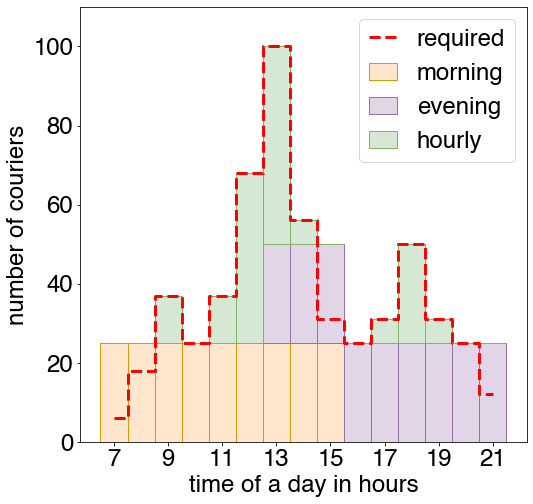

In [56]:
def solve(required_supply, max_part_time_per_hour, shift_padding = 0):
    full_time = np.zeros((2, hours.size))
    for j in range(shift_padding, 9 + shift_padding):
        full_time[0][j] = 1
    for j in range(hours.size - (9 + shift_padding), hours.size - shift_padding):
        full_time[1][j] = 1
    slack_time = np.zeros((hours.size, hours.size))
    np.fill_diagonal(slack_time, -1)
    part_time = np.zeros((hours.size, hours.size))
    np.fill_diagonal(part_time, 1)
    A_eq = np.vstack((full_time, slack_time, part_time)).transpose()
    B_eq = required_supply
    c = np.concatenate((np.full((np.size(full_time, 0)), 8), np.full(np.size(slack_time, 0), 1), np.full(np.size(part_time, 0), 1)), axis=0)
#     print(A_eq)
#     print(B_eq)
#     print(c)
    x_bounds = np.concatenate(([[0, 100]] * (np.size(full_time, 0) + np.size(slack_time, 0)), [[0, max_part_time_per_hour]] * np.size(part_time, 0)))
#     print(x_bounds)
#     x_bounds = None
    res = linprog(c, A_eq = A_eq, b_eq = B_eq, bounds = x_bounds, method = 'interior-point')
#     print(res)
    return np.round(np.array(res.x))

def plot(shifts, ideal, shift_padding = 0):
    full_time = np.zeros((2, hours.size))
    for j in range(shift_padding, 9 + shift_padding):
        full_time[0][j] = shifts[0]
    for j in range(hours.size - (9 + shift_padding), hours.size - shift_padding):
        full_time[1][j] = shifts[1]
    part_time = np.zeros((hours.size, hours.size))
    row, col = np.diag_indices(part_time.shape[0])
    part_time[row, col] = shifts[(2 + hours.size):]
#     print(part_time)
    all_time = np.concatenate([full_time, part_time])
    print(np.sum(busy) / np.sum(all_time))
    _, ax = plt.subplots(figsize = (8, 8))
    ax.set_xlabel('time of a day in hours')
    ax.set_ylabel('number of couriers')
    ax.set_ylim(0, max(np.sum(full_time, axis = 0) + np.sum(part_time, axis = 0)) + 10)
    ax.bar(hours, full_time[0], width = 1, color = '#FFE6CC', edgecolor = '#D79B00', label = 'morning')
    ax.bar(hours, full_time[1], width = 1, bottom = full_time[0], color = '#E1D5E7', edgecolor = '#9673A6', label = 'evening')
    ax.bar(hours, np.sum(part_time, axis = 0), width = 1, bottom = np.sum(full_time, axis = 0), color = '#D5E8D4', edgecolor = '#82B366', label = 'hourly')
    ax.step(hours, ideal, where='mid', linewidth = 3, linestyle = 'dashed', color = 'red', label = 'required')
    ax.legend(loc = 'upper right', handlelength = 1.2)
    plt.xticks(np.delete(hours, np.arange(1, hours.size, 2)))
    plt.savefig('shifts.svg')

0.4190207156308851


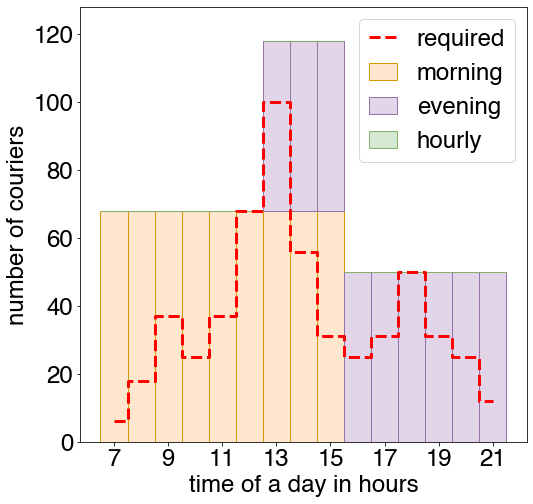

In [58]:
plot(solve(optimal, 0), optimal)

0.7295081967213115


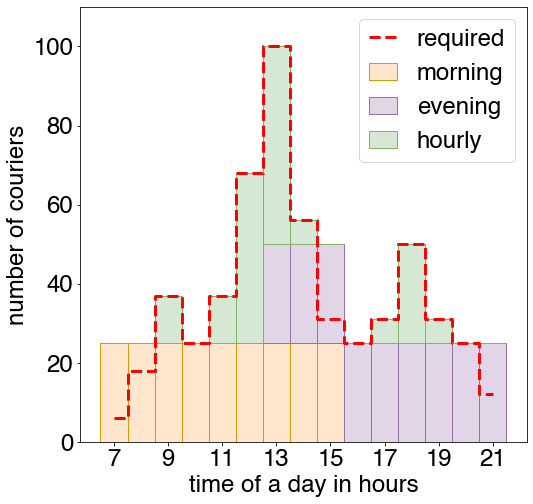

In [59]:
plot(solve(optimal, 50), optimal)